In [127]:
%matplotlib inline

import pandas as pd
import numpy as np

#packages for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()

#packages for model development
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
# url link to the csv file for importing college scorecard data
url = 'https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-All-Data-Elements.csv'

In [5]:
# url link to the excel file for importing data dictionary
url1 = 'https://collegescorecard.ed.gov/assets/CollegeScorecardDataDictionary.xlsx'

In [6]:
xl = pd.ExcelFile (url1)

In [7]:
#getting data dictionary
data_dict = xl.parse('data_dictionary')

In [8]:
data_dict.head()

,NAME OF DATA ELEMENT,dev-category,developer-friendly name,API data type,VARIABLE NAME,VALUE,LABEL,SOURCE,NOTES
0,Unit ID for institution,root,id,integer,UNITID,NaN,NaN,IPEDS,Shown/used on consumer website.
1,8-digit OPE ID for institution,root,ope8_id,integer,OPEID,NaN,NaN,IPEDS,Shown/used on consumer website.
2,6-digit OPE ID for institution,root,ope6_id,integer,OPEID6,NaN,NaN,IPEDS,Shown/used on consumer website.
3,Institution name,school,name,autocomplete,INSTNM,NaN,NaN,IPEDS,Shown/used on consumer website.
4,City,school,city,autocomplete,CITY,NaN,NaN,IPEDS,Shown/used on consumer website.


In [9]:
#Unique categories from data dictionary
data_dict['dev-category'].unique()

array(['root', 'school', nan, 'admissions', 'academics', 'student', 'cost',
       'aid', 'completion', 'repayment', 'earnings'], dtype=object)

In [10]:
#getting columns from completion
data_columns = data_dict.loc[data_dict['dev-category'].isin (['root', 'school','admissions','academics','cost'])]['VARIABLE NAME']

In [11]:
data_columns1 = data_columns.dropna().tolist()

In [12]:
#remove columns starting with CIP
data_columns2 = [col for col in data_columns1 if (col[:3] =='CIP')]

In [13]:
# Several values in the columns are represented as PrivacySuppressed: replacing them with NULL
df = pd.read_csv(url, na_values=['PrivacySuppressed'])

C:\Users\harshvardhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6,9,1729,1743) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
df1 = df[data_columns1]

In [15]:
df1 = df1.drop(data_columns2, axis=1)

In [16]:
#adding income column to the dataframe that will be predicted using other variables
df1['Income'] = df['MD_EARN_WNE_P10']

In [17]:
df1.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,ALIAS,ICLEVEL,OPENADMP,ACCREDCODE,T4APPROVALDATE,Income
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,...,9657.0,7941.0,7017.0,0.7096,AAMU,1,2.0,SACSCC,12/12/1965,29900.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,10263.0,17548.0,10221.0,0.9081,NaN,1,2.0,SACSCC,12/1/1965,40200.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,17071.0,7113.0,3217.0,1.0000,Southern Christian University |Regions University,1,1.0,SACSCC,3/26/1987,40100.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,8917.0,10619.0,9514.0,0.6173,UAH |University of Alabama Huntsville,1,2.0,SACSCC,12/1/1965,45600.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,7717.0,7742.0,7940.0,0.6395,NaN,1,2.0,SACSCC,12/1/1965,26700.0


In [18]:
# separating the first digit of Zip to divide schools according to regions from 0 to 9 as categories
df1['ZIP1'] = df1['ZIP'].map(lambda x: int(str(x)[:1]))

In [19]:
df1['ZIP1'].head()

0    3
1    3
2    3
3    3
4    3
Name: ZIP1, dtype: int64

In [20]:
#We developed a separate table using UNITID, name, city and state since these can only be used to identify school
schools = df1[['UNITID', 'INSTNM', 'CITY', 'STABBR']]

In [21]:
schools.head()

,UNITID,INSTNM,CITY,STABBR
0,100654,Alabama A & M University,Normal,AL
1,100663,University of Alabama at Birmingham,Birmingham,AL
2,100690,Amridge University,Montgomery,AL
3,100706,University of Alabama in Huntsville,Huntsville,AL
4,100724,Alabama State University,Montgomery,AL


In [22]:
#Deleting the columns that cant be used for model development: Zip, lat, long, opeid, opeid6, accreditor, school_url, price-calculator_url, repayment_date.median
#separation_date.median, alias, accreditor_code, title_iv.approval_date
other_columns = ['INSTNM', 'CITY','STABBR','OPEID', 'ST_FIPS', 'REGION', 'LOCALE', 'LOCALE2','OPEID6', 'ZIP','ACCREDAGENCY','LATITUDE', 'ALIAS','LONGITUDE', 'INSTURL','NPCURL','ACCREDCODE','T4APPROVALDATE']

In [23]:
df1.drop(other_columns, axis = 1, inplace =True)

In [24]:
df1.shape

(7593, 159)

In [25]:
# checking head of the data
df1.head()

,UNITID,SCH_DEG,HCM2,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,CCBASIC,CCUGPROF,...,TUITIONFEE_OUT,TUITIONFEE_PROG,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,ICLEVEL,OPENADMP,Income,ZIP1
0,100654,3.0,0,1,1,3,4,1,18.0,10.0,...,17136.0,NaN,9657.0,7941.0,7017.0,0.7096,1,2.0,29900.0,3
1,100663,3.0,0,1,1,3,4,1,15.0,9.0,...,17654.0,NaN,10263.0,17548.0,10221.0,0.9081,1,2.0,40200.0,3
2,100690,3.0,0,1,1,3,4,2,21.0,5.0,...,6900.0,NaN,17071.0,7113.0,3217.0,1.0000,1,1.0,40100.0,3
3,100706,3.0,0,1,1,3,4,1,15.0,9.0,...,20622.0,NaN,8917.0,10619.0,9514.0,0.6173,1,2.0,45600.0,3
4,100724,3.0,0,1,1,3,4,1,18.0,10.0,...,15656.0,NaN,7717.0,7742.0,7940.0,0.6395,1,2.0,26700.0,3


In [26]:
# checking the dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Columns: 159 entries, UNITID to ZIP1
dtypes: float64(149), int64(10)
memory usage: 9.2 MB


In [27]:
#setting UNITID as the index
df1.set_index('UNITID', inplace=True)

In [28]:
#dropping rows those are null in the income column
Inc_null = df1.Income.isnull()

In [29]:
df2 = df1.dropna(subset=['Income'], how='all')

In [30]:
#checking for columns with less than 40 percent of null data
columns = df2.isnull().sum()/df2.shape[0]*100 < 40  

In [31]:
df3 = df2.loc[:,columns]

In [32]:
df3.head()

,SCH_DEG,HCM2,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,CCBASIC,CCUGPROF,CCSIZSET,...,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,ICLEVEL,OPENADMP,Income,ZIP1
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,3.0,0,1,1,3,4,1,18.0,10.0,13.0,...,9366.0,17136.0,9657.0,7941.0,7017.0,0.7096,1,2.0,29900.0,3
100663,3.0,0,1,1,3,4,1,15.0,9.0,15.0,...,7766.0,17654.0,10263.0,17548.0,10221.0,0.9081,1,2.0,40200.0,3
100690,3.0,0,1,1,3,4,2,21.0,5.0,6.0,...,6900.0,6900.0,17071.0,7113.0,3217.0,1.0000,1,1.0,40100.0,3
100706,3.0,0,1,1,3,4,1,15.0,9.0,12.0,...,9128.0,20622.0,8917.0,10619.0,9514.0,0.6173,1,2.0,45600.0,3
100724,3.0,0,1,1,3,4,1,18.0,10.0,13.0,...,8720.0,15656.0,7717.0,7742.0,7940.0,0.6395,1,2.0,26700.0,3


In [33]:
#checking for nan values
np.where(np.isnan(df2))

(array([   0,    0,    0, ..., 5681, 5681, 5681], dtype=int64),
 array([ 19,  37,  38, ..., 152, 153, 155], dtype=int64))

In [34]:
#filling the null data with median
df3.fillna(df3.median(), inplace=True).head()

C:\Users\harshvardhan\Anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,SCH_DEG,HCM2,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,CCBASIC,CCUGPROF,CCSIZSET,...,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,ICLEVEL,OPENADMP,Income,ZIP1
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,3.0,0,1,1,3,4,1,18.0,10.0,13.0,...,9366.0,17136.0,9657.0,7941.0,7017.0,0.7096,1,2.0,29900.0,3
100663,3.0,0,1,1,3,4,1,15.0,9.0,15.0,...,7766.0,17654.0,10263.0,17548.0,10221.0,0.9081,1,2.0,40200.0,3
100690,3.0,0,1,1,3,4,2,21.0,5.0,6.0,...,6900.0,6900.0,17071.0,7113.0,3217.0,1.0000,1,1.0,40100.0,3
100706,3.0,0,1,1,3,4,1,15.0,9.0,12.0,...,9128.0,20622.0,8917.0,10619.0,9514.0,0.6173,1,2.0,45600.0,3
100724,3.0,0,1,1,3,4,1,18.0,10.0,13.0,...,8720.0,15656.0,7717.0,7742.0,7940.0,0.6395,1,2.0,26700.0,3


In [35]:
# finding columns (starts with 'PCIP')that represent percentage of students in different programs and those with less that 90% zeroes
PCIP_main =  []
for col in df2.columns:
    if (col[:4] ==  'PCIP') and (((df2[col] == 0).sum()/df2[col].count()) < 0.9):
        PCIP_main.append(col)
        
print(PCIP_main)

['PCIP01', 'PCIP03', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11', 'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24', 'PCIP26', 'PCIP27', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP40', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP50', 'PCIP51', 'PCIP52', 'PCIP54']


In [36]:
df4 = df3.drop(PCIP_main, axis =1)

In [37]:
y = df4['Income']

In [38]:
X = df4.drop('Income', axis=1)

In [39]:
#intializing random forest regressor
clf = RandomForestRegressor()

In [40]:
# dataframe with just features that have a feature importance > .005 in the random forrest
sfm = SelectFromModel(clf, threshold=0.005)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]
features = sfm.transform(X)

In [41]:
n_features

20

In [42]:
sfm.get_support(indices=True)

array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 24, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36], dtype=int64)

In [43]:
df5 = df4.iloc[:,sfm.get_support(indices=True)]

In [44]:
df5.describe()

,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,CONTROL,CCBASIC,CCUGPROF,CCSIZSET,HBCU,PCIP49,COSTT4_A,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,ICLEVEL,OPENADMP,Income
count,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000
mean,1.998416,0.705033,8.898803,1.881204,2.079725,9.438050,4.618092,4.815910,0.016719,0.007906,24841.648187,14128.023231,16933.383844,10318.165963,7516.398275,6365.685674,0.559107,1.724569,1.350229,33500.422386
std,0.858906,0.456068,24.067041,0.975570,0.854787,10.482941,5.488964,5.647347,0.128230,0.062685,10852.149585,9767.553784,8848.326199,7856.375276,9596.661897,1911.070702,0.234790,0.777019,0.477083,15444.584400
min,1.000000,0.000000,1.000000,0.000000,1.000000,-3.000000,-2.000000,-2.000000,0.000000,0.000000,4559.000000,580.000000,580.000000,0.000000,0.000000,1140.000000,0.000000,1.000000,1.000000,9100.000000
25%,1.000000,0.000000,1.000000,1.000000,1.000000,-3.000000,-2.000000,-2.000000,0.000000,0.000000,19955.750000,8061.250000,12975.000000,4766.250000,4026.750000,5515.250000,0.444550,1.000000,1.000000,24100.000000
50%,2.000000,1.000000,1.000000,2.000000,2.000000,10.000000,4.000000,4.000000,0.000000,0.000000,23413.000000,12672.000000,15352.000000,9352.000000,5998.000000,6168.000000,0.541100,2.000000,1.000000,31100.000000
75%,3.000000,1.000000,4.000000,3.000000,3.000000,19.000000,10.000000,9.000000,0.000000,0.000000,26781.750000,15675.000000,18048.000000,14020.750000,8426.750000,6869.750000,0.642850,2.000000,2.000000,39500.000000
max,3.000000,1.000000,135.000000,4.000000,3.000000,33.000000,15.000000,18.000000,1.000000,1.000000,67572.000000,53000.000000,53000.000000,147403.000000,393969.000000,26084.000000,1.000000,3.000000,2.000000,250000.000000


In [45]:
df5.columns

Index(['SCH_DEG', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'CONTROL', 'CCBASIC',
       'CCUGPROF', 'CCSIZSET', 'HBCU', 'PCIP49', 'COSTT4_A', 'TUITIONFEE_IN',
       'TUITIONFEE_OUT', 'TUITFTE', 'INEXPFTE', 'AVGFACSAL', 'PFTFAC',
       'ICLEVEL', 'OPENADMP', 'Income'],
      dtype='object')

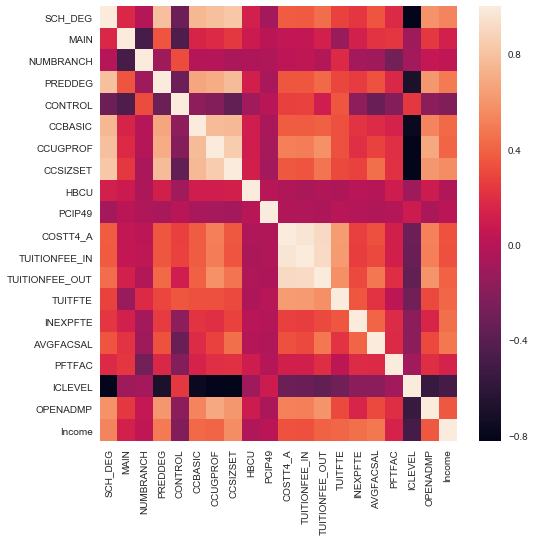

In [46]:
#checking covariance using heatmap
corr = df5.corr()
_ = plt.figure(figsize = (8,8))
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

The heatmap above shows that average cost of attendance (COSTT4_A) and tution Fee (TUTIONFEE_IN) are highly correlated. So we can look into it more using scatter plot and regression line.

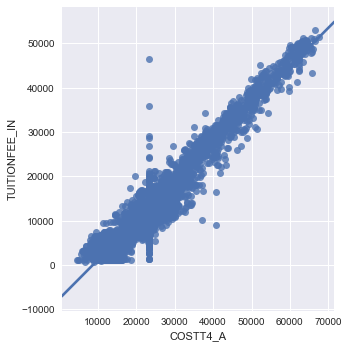

In [47]:
_ = sns.lmplot(x='COSTT4_A', y='TUITIONFEE_IN', data=df5)

The lmplot further confirms that both average cost of attendance are stronly correlated. This suggest that we can use one variable TUTIONFEE_IN to avoid multicollinearity.

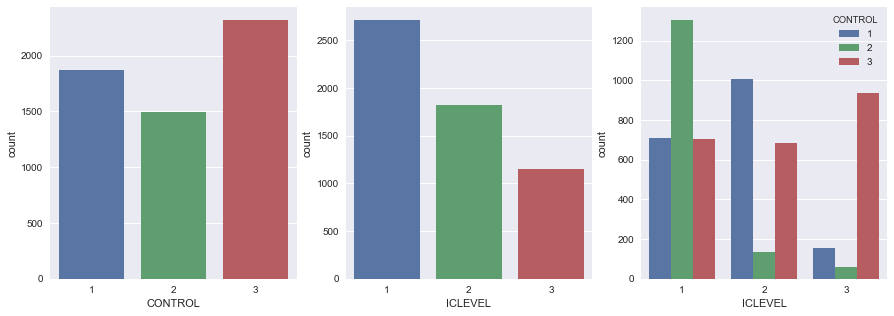

In [48]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))
_ = sns.countplot(x='CONTROL', data=df5, ax=ax1)
_ = sns.countplot(x='ICLEVEL', data=df5, orient="v", ax=ax2)
_ = sns.countplot(x='ICLEVEL', data=df5, hue='CONTROL', ax=ax3)

In the above count plots CONTROL variable represent control of institution (1:Public, 2:Private Non-profit, 3:Private for-profit), ICLEVEL represents level of instituion (1: 4-year, 2:2year, 3:less than 2years).

One of the things that can be noticed clearly from the above plots is that the number of 4-year intitutions are higher than the other two categories. Another interesting observation from the 3rd plot is that colleges offering less than 2-year courses are mostly private institutions that are operated for profit.

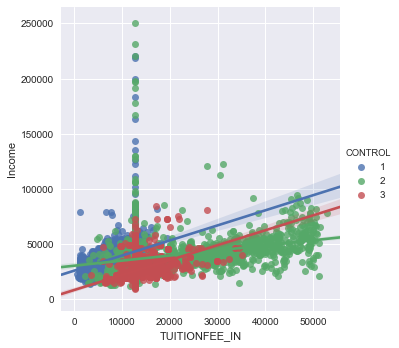

In [49]:
_ = sns.lmplot(x='TUITIONFEE_IN', y='Income', hue='CONTROL', data=df5)

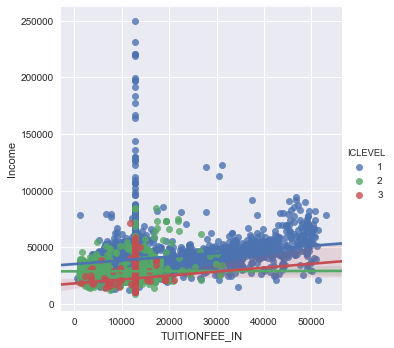

In [50]:
_ = sns.lmplot(x='TUITIONFEE_IN', y='Income', hue='ICLEVEL', data=df5)

From the above plots it is hard to tell if there are any clear trends between the tuition fee (instate) and Income for colleges under different controls (public or private) or different ICLEVEL. We do notice a group of colleges with same tuition fee having high variablity of income. Upon further investigation it was noticed that these are the colleges with missing tuition and were filled with median tuition.

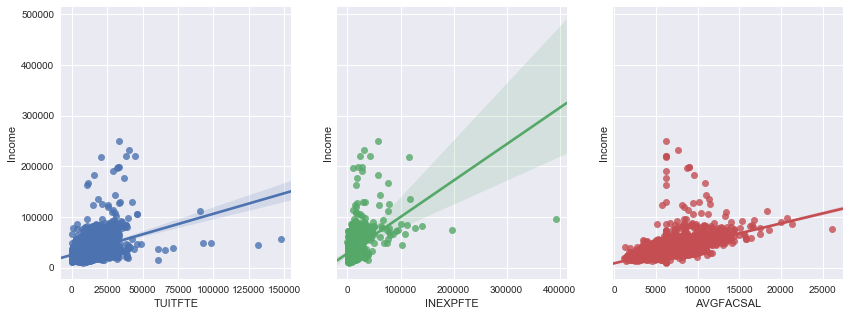

In [51]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, sharey=True, figsize=(14,5))
_ = sns.regplot(x='TUITFTE', y='Income', data=df5, ax=ax1)
_ = sns.regplot(x='INEXPFTE', y='Income', data=df5, ax=ax2)
_ = sns.regplot(x='AVGFACSAL', y='Income',data=df5, ax=ax3)

It is interesting to see that there appears to be a positive correlation between average faculty salary (AVGFACSAL), Instructional expenditures per full-time equivalent student (INEXPFTE), Net tuition revenue per full-time equivalent student (TUITFTE),  and the median income. Which suggest if schools focus more on spending on the faculty and other instructional expenditures, the quality of education will be better resulting in students earning more salary after they graduate.

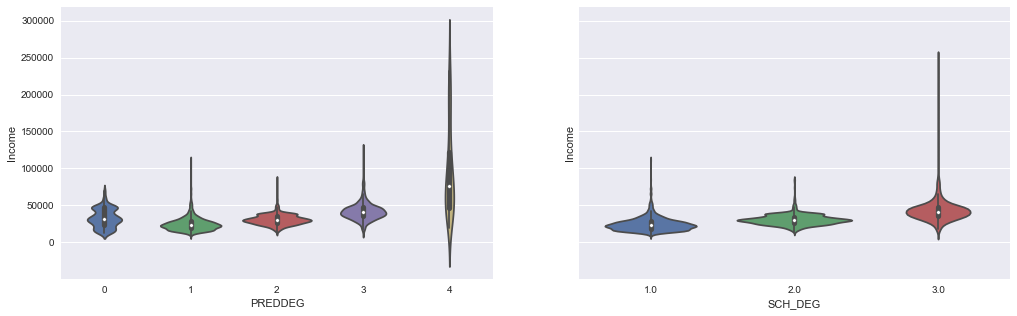

In [52]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(17,5))

_ = sns.violinplot(x='PREDDEG', y='Income', data=df5, ax=ax1)
_ = sns.violinplot(x='SCH_DEG', y='Income', data=df5, ax=ax2)


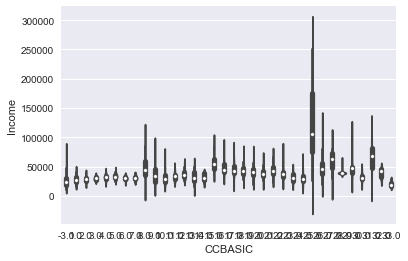

In [53]:
_ =sns.violinplot(x='CCBASIC', y='Income', data=df5)
_ =sns.set(rc={'figure.figsize':(18,5)})

The above plot shows the income spread for different colleges based on their carnegie classification. While most of the colleges does not show big differences in their median income salary, it is evident from the plot that average of the median salaries for students graduating from doctoral universities that focus more research is more than 100k.

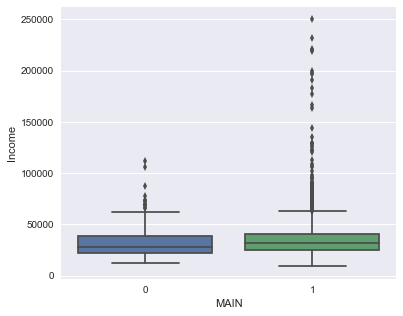

In [55]:
_ = sns.boxplot(x='MAIN', y='Income',data=df5)
_ = sns.set(rc={'figure.figsize':(6,5)})

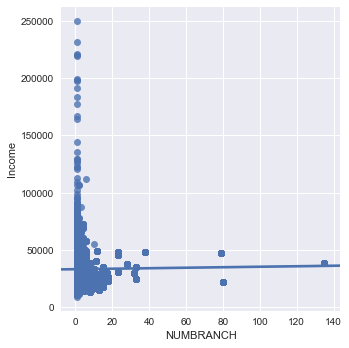

In [56]:
_ = sns.lmplot(x='NUMBRANCH', y='Income', data=df5)

Above plot reveals that there is group of colleges with 1 branch that have high variability of Income. Upon further investigation it was noticed that this group is for the colleges that had missing NUMBRANCH and were filled using the median.

So, we might have to drop this variable or fill the missing NUMBRANCH using a different criteria.

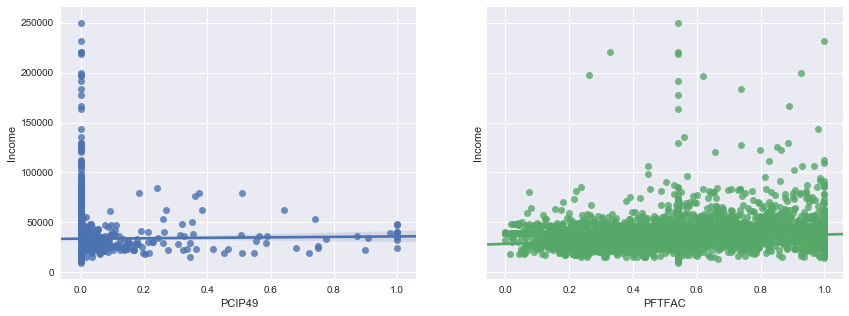

In [57]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
_ = sns.regplot(x='PCIP49', y='Income', data=df5, ax=ax1)
_ = sns.regplot(x='PFTFAC', y='Income', data=df5, ax=ax2)

It was noticed that several colleges had missing or 0 PCIP values resulting in a group of colleges with high income variability. 

Also there was no clear trend between proportion of faculty that are permanent (PFTAC) and median income.

Inferential statistics.

    Check the collinearity between cost of attendance and tution fee

    Null hypothesis: Cost of attendance and tution fee are completely uncorrelated
    Alternate hypothesis: Cost of attendance and tution fee are correlated

In [58]:
#calculate observed pearson correlation coefficient: obs_r 
x = df5['COSTT4_A']
y = df5['TUITIONFEE_IN']
obs_r = np.corrcoef(x,y)[0,1]
print(obs_r)

0.968703429182


In [59]:
alpha = 0.05

In [60]:
#test the hypothesis 
#initialize the permutation replicates for correlation coefficients: per_coef
per_coef = np.empty(10000)

#draw replicates
for i in range(10000):
    #generate permutation for cost of admission: perm_cost
    perm_cost = np.random.permutation(x)
    
    #compute correlation coefficients for permuted costs and tution fee
    per_coef[i] = np.corrcoef(perm_cost, y)[0,1]
    
#calculate p-value
p_coef = np.sum(per_coef >= obs_r)/len(per_coef)

In [61]:
if p_coef <= alpha:
    print('We can reject the null hypothesis at alpha=0.05 with p-value = ' + str(p_coef))
else:
    print('We cannot reject the null hypothesis at alpha=0.05 with p-value = ' + str(p_coef))

We can reject the null hypothesis at alpha=0.05 with p-value = 0.0


From the above the hypothesis we can say that cost of attendance and tution fee are significantly correlated. Since the estimated r-square value is really high (approx 0.97) we can say that the correlation between cost of attendance and tution fee is also practically signifcant

    Null hypothesis: students from graduate level colleges have similar salaries to students from other colleges
    Alternate hypothesis: students from graduate level colleges have higher salaries compared to students from other colleges

In [62]:
#mean of salaries from all the colleges
obs_mean_all = np.mean(df5['Income'])
print(obs_mean_all)

33500.42238648363


In [63]:
#sepearte income of colleges offering predominantly graduate degrees and get there mean
df5_graduate = df5[df5['PREDDEG']==4]['Income']
df5_grad_mean = np.mean(df5_graduate)
print(df5_grad_mean)

94447.05882352941


In [64]:
#sepearte income of colleges offering predominantly other degrees and get there mean
df5_other_degrees = df5[df5['PREDDEG'] !=4]['Income']
df5_oth_mean = np.mean(df5_other_degrees)
print(df5_oth_mean)

32762.20163876024


In [65]:
#calculate empirical difference in mean
emp_mean_diff = df5_grad_mean - df5_oth_mean
print(emp_mean_diff)

61684.85718476917


In [66]:
#shift both the dataset to have similar mean
df5_grad_shifted = df5_graduate - df5_grad_mean + obs_mean_all
df5_oth_shifted = df5_other_degrees - df5_oth_mean + obs_mean_all

In [67]:
#bootstrap method to generate bootstrap replicates
def bs_rep(data, func, size=1):
    #initialize an empty array 
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)
    return bs_replicates

In [68]:
#draw bootstrap replicates of shifted means
bs_grad_shifted = bs_rep(df5_grad_shifted, np.mean, 10000)
bs_oth_shifted = bs_rep(df5_oth_shifted, np.mean, 10000)

In [69]:
#calculate differences in replicates
bs_diff_mean = bs_grad_shifted - bs_oth_shifted

In [70]:
#calculate p-value and compare with alpha
p = np.sum(bs_diff_mean >= emp_mean_diff)/len(bs_diff_mean)

if p <= alpha:
    print('We can reject the null hypothesis at alpha=0.05 with p-value = ' + str(p))
else:
    print('We cannot reject the null hypothesis at alpha=0.05 with p-value = ' + str(p))

We can reject the null hypothesis at alpha=0.05 with p-value = 0.0


In [71]:
#use stats package to double check the results
t1, p1 = stats.ttest_ind(df5_graduate, df5_other_degrees)

print(t1, p1)
if p1 <= alpha:
    print('We can reject the null hypothesis at alpha=0.05 with p-value = ' + str(p1))
else:
    print('We cannot reject the null hypothesis at alpha=0.05 with p-value = ' + str(p1))

36.3412954344 3.43478996627e-260
We can reject the null hypothesis at alpha=0.05 with p-value = 3.43478996627e-260


Both the bootstrap test and 2-sample ttest using stats package suggest that the salaries for students graduating from colleges offering graduate level degrees is significantly higher as compared to students graduating from other colleges. 
The empirical difference between the means is approx $61,685 suggesting that the difference is pratically significant as well.

    Check the normality of the Income data
        Null hypothesis: Income data is normally distributed
        Alternate hypothesis: Income data is not normally distributed

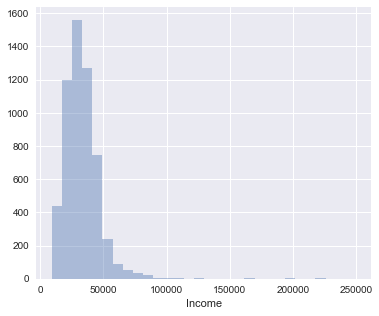

In [72]:
#draw a histogram to check the distribution of income
_ = sns.distplot(df5['Income'], bins=30, kde=False)

In [73]:
#plot the ecdf of observed data and compare it with the theoritical ecdf
#define function to calculate x and y variables for plotting ecdf

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1)/len(data)
    return x, y

In [74]:
#x and y for plotting ecdf of observed data
x_obs, y_obs = ecdf(df5.Income)

In [75]:
#estimate x and y for theoritical samples for ecdf
mean = np.mean(df5.Income)
std = np.std(df5.Income)
samples = np.random.normal(mean, std, 10000)

x_theo, y_theo = ecdf(samples)

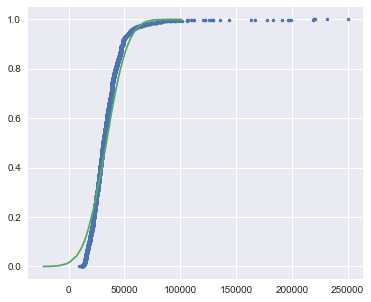

In [76]:
#plot ecdfs using the actual and theoritical observations 
_ = plt.plot(x_obs, y_obs, marker='.', linestyle='none')
_ = plt.plot(x_theo, y_theo)

In [77]:
chi, p_income = stats.chisquare(df5.Income)
print(chi, p_income)

40450785.4663 0.0


In [78]:
if p_income <= alpha:
    print('We can reject the null hypothesis at alpha=0.05 with p-value = ' + str(p_income))
else:
    print('We cannot reject the null hypothesis at alpha=0.05 with p-value = ' + str(p_income))

We can reject the null hypothesis at alpha=0.05 with p-value = 0.0


Both graphically and chi square test suggest that the data is not normally distributed. The plots also suggest that while the data in the middle follow a normal trend. The income for colleges at the extreme low and high ends deviate the plot from being normally distributed.

In [79]:
#get lof of income data
log_inc = np.log(df5.Income)

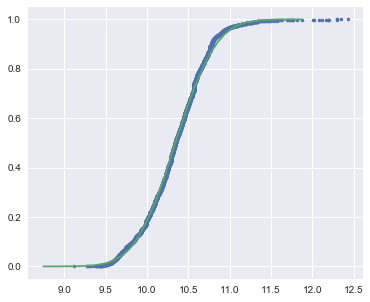

In [80]:
#plot ecdf for log of Income
x_log, y_log = ecdf(log_inc)
x_theo_log, y_theo_log = ecdf(np.random.normal(np.mean(log_inc), np.std(log_inc), 10000))

_ = plt.plot(x_log, y_log, marker='.', linestyle='none')
_ = plt.plot(x_theo_log, y_theo_log)

In [81]:
#chi square test to check normality of lof of income
chi1, p_log_inc = stats.chisquare(log_inc)
print(chi1, p_log_inc)

81.1668617712 1.0


Both the ecdf plots and chi-square test suggest that Income data is normally distributed after log transformation.

Developing Random Forest Regressor and Elastic Net Models using Grid Search method and comparing the model performances

In [189]:
#specify independent and response/dependent variable: X, y
X = df5.drop('Income', axis=1)
y = df5.Income

In [190]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

In [193]:
#Instantiate Random Forest Regressor: regr
regr = RandomForestRegressor()

In [192]:
#Specify range of hyperparameters to be tested using Grid Search
parameters = {"max_depth": list(range(1,10))
              , "min_samples_split": [50,100,200]
              , "n_estimators": list(range(1,5))
              , "max_features": list(range(2,20))  }

In [196]:
# Instantiate the GridSearchCV object: regr_cv
regr_cv =  GridSearchCV(regr, parameters, cv=5)

In [197]:
#Fit the model to training data
regr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [50, 100, 200], 'n_estimators': [1, 2, 3, 4], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [198]:
print("Tuned Random Forest Regressor Parameters: {}".format(regr_cv.best_params_))
print("Best Score is: {}".format(regr_cv.best_score_))

Tuned Random Forest Regressor Parameters: {'max_depth': 9, 'max_features': 10, 'min_samples_split': 50, 'n_estimators': 4}
Best Score is: 0.6082351549586233


In [200]:
#Test the model on test dataset
y_pred = regr_cv.predict(X_test)

In [118]:
print("R^2: {}".format(regr.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.5852595578709596
Root Mean Squared Error: 10175.746040092701


The results show that Random Forest Regressor does a decent job in predicting the Income with an R-square of almost 0.59

In [122]:
#Instantiate Elastic Net: elastic_net
elastic_net = ElasticNet()

In [ ]:
#Specify range of hyperparameter to be tested using Grid Search
param_en = {"l1_ratio": np.linspace(0, 1, 30)}

In [124]:
# Instantiate the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_en, cv=5)

In [125]:
#Fit the model
gm_cv.fit(X_train, y_train)

C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.     ,  0.03448,  0.06897,  0.10345,  0.13793,  0.17241,
        0.2069 ,  0.24138,  0.27586,  0.31034,  0.34483,  0.37931,
        0.41379,  0.44828,  0.48276,  0.51724,  0.55172,  0.58621,
        0.62069,  0.65517,  0.68966,  0.72414,  0.75862,  0.7931 ,
        0.82759,  0.86207,  0.89655,  0.93103,  0.96552,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [126]:
#Test the model on test dataset
y_pred_net = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_net)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.5460378246450649
Tuned ElasticNet MSE: 113338066.97938824


Although the Elastic Net model did perform well with R2 of 0.54, its performance was less compared to the Random Forest Regressor

Scaling the data and applying the models again using Pipeline

In [160]:
#Setup pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('regr_sc' , RandomForestRegressor())]

In [163]:
#Instantiate the pipeline
pipeline_regr = Pipeline(steps)

In [166]:
#Specify range for hyperparameters: parameters_reg
parameters_reg = {"regr_sc__max_depth": list(range(1,10))
              , "regr_sc__min_samples_split": [50,100,200]
              , "regr_sc__n_estimators": list(range(1,5))
              , "regr_sc__max_features": list(range(2,20))  }

In [167]:
#Random Forest Regressor after standard scaling: regr_cv_sc
regr_cv_sc =  GridSearchCV(pipeline_regr, param_grid=parameters_reg)

In [168]:
#Fit the model
regr_cv_sc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr_sc', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regr_sc__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'regr_sc__min_samples_split': [50, 100, 200], 'regr_sc__n_estimators': [1, 2, 3, 4], 'regr_sc__max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [171]:
print("Tuned Random Forest Regressor Parameters: {}".format(regr_cv_sc.best_params_))
print("Best Score is: {}".format(regr_cv_sc.best_score_))

Tuned Random Forest Regressor Parameters: {'regr_sc__max_depth': 9, 'regr_sc__max_features': 15, 'regr_sc__min_samples_split': 50, 'regr_sc__n_estimators': 4}
Best Score is: 0.6193168798523947


In [172]:
y_pred_reg = regr_cv_sc.predict(X_test)

In [174]:
print("R^2: {}".format(regr_cv_sc.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6485288263798779
Root Mean Squared Error: 9367.483185640427


The results show that after scaling the Random Forest Regression model is performing better. The R-square increased from almost 0.59 to 0.65 and RMSE decreased from  10175.75 to 9367.48

Scaling the data and applying the Elastic Net model again using Pipeline

In [177]:
#Setup pipeline steps: steps
steps_en = [('scaler', StandardScaler()),
        ('elastic_net_sc' , ElasticNet())]

In [178]:
#Instantiate the pipeline
pipeline_en = Pipeline(steps_en)

In [182]:
# Specify the hyperparameter space
param_en_sc = {'elastic_net_sc__l1_ratio':np.linspace(0,1,30)}

In [203]:
#ElasticNet after standard scaling: elastic_cv_sc
elastic_cv_sc =  GridSearchCV(pipeline_en, param_grid=param_en_sc, cv=5)

In [204]:
#Fit the model
elastic_cv_sc.fit(X_train, y_train)

C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harshvardhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic_net_sc', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elastic_net_sc__l1_ratio': array([ 0.     ,  0.03448,  0.06897,  0.10345,  0.13793,  0.17241,
        0.2069 ,  0.24138,  0.27586,  0.31034,  0.34483,  0.37931,
        0.41379,  0.44828,  0.48276,  0.51724,  0.55172,  0.58621,
        0.62069,  0.65517,  0.68966,  0.72414,  0.75862,  0.7931 ,
        0.82759,  0.86207,  0.89655,  0.93103,  0.96552,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [205]:
y_pred_net_sc = elastic_cv_sc.predict(X_test)
r2 = elastic_cv_sc.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_net_sc)
print("Tuned ElasticNet l1 ratio: {}".format(elastic_cv_sc.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'elastic_net_sc__l1_ratio': 0.96551724137931028}
Tuned ElasticNet R squared: 0.5391314798850932
Tuned ElasticNet MSE: 115062333.46563551
